# Anatomy of a Hit Song: Understanding the song characteristics that make it to the top

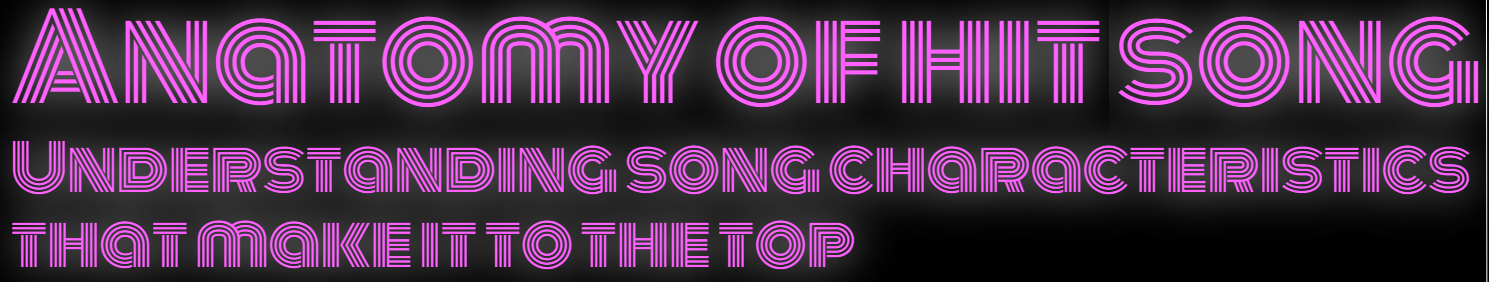

In [3]:
display(Image('./img/banner.PNG'))

## Executive Summary

<p style="text-align:justify">Popular music is a bulti-million dollar industry today. However, the genre is derided as the worst kind of music for its repetitive, almost formulaic, and yet commercially successful style. The objective of this study is to get a glimpse of this formula and understand the audio features that land songs at the top of the charts. Using the 2010-2019 Spotify Hits Predictor Dataset from Kaggle, we conduct statistical tests and perform a logistic regression to find out what makes hits or flops.
<br><br>
Looking into the general composition of audio features between hits and flops, we identified significant differences in group means using Mann-Whitney U test for our non-normally distributed variables. We then assessed the validity of the model and its potential predictors by testing for multicollinearity and linearity with log-odds. Some variables were dropped to meet the assumptions of a logistic regression to allow for valid interpretations of the resulting summary statistics. After implementing a grid search over 10 trials and 10 splits, we then implemented an L1-regularized logistic regression using the C parameter with the highest accuracy.
<br><br>
The optimized logistic regression has an accuracy score of 78 percent. Based on the summary statistics, we derived the following insights:
<li>Danceability is the top positive predictor of hits songs.</li>
<li>Valence which represents the level of positivity also increases a song's likelihood of charting.</li>
<li>Instrumentalness appears to be the top yet negative predictor of hit songs, even exceeding danceability and valence combined.</li>
<br>
We have confirmed that a balance of certain features can contribute to a song's mass appeal and can land it at the top of the charts. Insights gleaned from this study can help artists and music producers find commercial success by producing songs that fit the standard features of those that land on the charts. Finally, record companies can also use this to predict the potential success of the songs they intend to release. </p>

In [2]:
# Import libraries
import base64
import datetime as datetime
import time
from tqdm import tqdm
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import matplotlib.patches as mpatches
import statsmodels.api as sm

import pandas as pd
import sqlite3

import requests
from urllib.parse import urlencode
from bs4 import BeautifulSoup

from scipy.stats import shapiro, kstest, mannwhitneyu
from scipy.stats import probplot

tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import IPython

from IPython.core.display import HTML, Image
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    horizontal-align: middle;
    vertical-align: middle;
    margin:auto;
}
</style>

<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>
""")

## I. Introduction

<p style="text-align:justify"> Music is the art of arranging sounds in time to produce a composition through the elements of melody, harmony, rhythm, and timbre.$^1$ As one of the universal cultural aspects of all human societies, music seems magical in how it can relate and resonate with us on a visceral level. In fact, music is such a powerful catalyst that reactions range from humming along, to shedding tears and even, inspiring movement (physical and social). It is this power of music to evoke emotions and connect to people that has made it into the multi-billion dollar industry it is today.
<br><br>
Not all music is created equal however. There are music that resonate and there are those that just slip by. Popular music is a type of music with wide appeal and is typically distributed to a large audience.$^2$ However, pop music is usually criticized as the worst genre of music due to its 'endless recycling'--copy-paste of successful songs with some superficial variation. And this is not entirely wrong. In fact, Backstreet Boys, Taylor Swift, Maroon 5, and Ariana Grande all share one thing in common: Max Martin, a Swedish songwriter who is considered the backbone of the modern pop scene. It is these catchy hooks and magical melodies created by Max Martin and other Swedish producers like him that have been topping the charts for the past 50 years.$^3$
<br><br>
So does music's power just come down to a carefully calculated formula? To answer this, we conduct statistical analysis and predictive modelling on the song features of hit songs and flops. This study can be useful for artists and music producers who want commercial success by producing songs that fit the standard features of those that land on the charts. Recording companies can also predict the potential success of songs they intend to release, based on the song's audio features.</p>

## II. Methodology

The methodology used in the study consists of 3 major steps as outlined below:
#### A. Perform EDA to explore  audio features
In performing exploratory data analysis, modules including <b>pandas</b>, <b>matplotlib</b> and <b>seaborn</b> were used to manipulate data and generate visualizations. Specifically, we aim to glean insights on the means and distributions of audio features using radar charts, histograms and boxplots. We also determine how the statistics for these audio features vary between hit songs and flops.

#### B. Statistical Tests
Taking a step further from EDA, we test whether the means of hit songs and flops are significantly different across our set of features. For this, we use Shapiro-Wilk's to test for normality so we can determine the appropriate test of means to use. We then use Mann-Whitney U test for non-normal distributions to check whether the means of the two groups are significantly different.

We also perform statistical tests on our model features to check whether they are viable for use in a logistic regression. The assumptions of logistic regressions are as follows:$^{4,5}$
1. <b>Binary dependent variable.</b>
Logistic regressions require that the dependent variable be binary or categorical with few classes. In oir case, we only have two outcomes, 1 for hit and 0 for flop. 
1. <b>Independent observations.</b> This assumption requires that the observations should not come from repeated measurements or matched data. In our case, each datapoint is an individual song and is thus independent of other observations.
1. <b>Little to no multicollinearity.</b> Multicollinearity corresponds to the situation in which the data contains highly correlated independent variables. Allowing this to be prevalent could hurt our ability to interpret the coefficients and analyze the model. Like in linear regressions, this assumption will be tested via variance inflation factor [VIF] and correlation plots.
1. <b>Linearity with log-odds.</b>  For linear regression, linearity of independent variables and the response variable is assumed whereas the linearity of independent variables and the log odds of the response variable is the case for logistic regression. To test this, we use the seaborn function regplot to fit a logistic regression model and visually inspect each feature for an S-shaped curve.
1. <b>Large sample size.</b> Logistic regression typically requires a large sample size.  A general guideline is that you need a minimum of 10 cases with the least frequent outcome for each independent variable in your model. Our 6,398 observations well covers the no more than 15 features of our model.

#### C. Logistic Regression
Once we have established that the variables are fit for use, we run a Logistic Regression. This classification model is easy and efficient to implement as well as offers interpretability not only in terms of feature importance, but the direction and marginal magnitude of the impact as well. For feature selection and to avoid overfitting, we implement the logistic regression with an L1-regularization.The steps are as follows:

1. <b>Scaling.</b> Since the features are in different units, we use the StandardScaler to transform the data. This is also meant to improve interpretability and model accuracy.

1. <b>L1-regularization.</b>To optimize our regularization, we find the best possible C parameter through Grid Search using Repeated Stratified KFold on 10 splits and 10 repeats.

1. <b>Summary. </b>We generate summary statistics using the optimized regularization parameter and analyze the resulting coefficients.

## III. Data Processing

### A. Load Dataset

The dataset is downloaded from Kaggle's Spotify Hits Predictor Database. We selected the 2010-2019 dataset to get the most recent and relevant results. The dataset has 6,398 songs with an equal number of hit songs and flops. The data is clean and complete with no missing values.

In [8]:
df = pd.read_csv('dataset-of-10s.csv')
display(HTML(f'''<h3 style="text-align:center"> Table 1:
                Sample Dataset
                </h3>'''))
df.head(3)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.020,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.871,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.161,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1


In [16]:
display(HTML(f'''<h3 style="text-align:center"> Table 2:
                Dataset has no null values
                </h3>'''))
pd.DataFrame(df.isnull().sum()).T

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### B. Data Descriptions

<p style="text-align:justify"> The dataset consists of audio features that describe each song’s sonic quality, from relatively objective musical characteristics, such as <code>key</code>, <code>mode</code>, and <code>tempo</code>, to more perceptual features that quantify a song’s <code>acousticness</code>, <code>energy</code>, and <code>danceability</code>, among others. The target is a binary variable where 1' implies that the song has been featured in the weekly list of the Billboard Hot-100 tracks in that decade at least once and is therefore a 'hit'. Meanwhile, '0' implies that the track is a 'flop' given the following conditions:$^6$</p>

- The track must not appear in the 'hit' list of that decade.

- The track's artist must not appear in the 'hit' list of that decade.

- The track must belong to a genre that could be considered non-mainstream and / or avant-garde. 

- The track's genre must not have a song in the 'hit' list.

- The track must have 'US' as one of its markets.

The variables are further described in the table below.$^7$

#### <center>Table 3: Description of Variables</center>
| Column | Data type | Description | 
| :---- | :---------: | :----- |
| `year` | integer | Year when the song was in the top 100 in the billboard site |
| `song_rank` | integer | Rank of the song during the year it was in the top 100 |
| `title` | string | Title of the song |
| `artist` | string | Artist of the song in Billboard |
| `spotify_id` | string | Song ID in Spotify |
| `spotify_track` | string | Track where the song is placed in Spotify |
| `spotify_artist` | string | Name of the artist in Spotify |
| `danceability` | float | Measure of how suitable a song is to dance to |
| `energy` | float | The song's "intensity" |
| `key` | int | Estimated overall key of the track. Integers map to pitches using standard pitch class notation |
| `loudness` | float | Magnitude of auditory sensation produced depending on the amplitude of the sound wave |
| `mode` | bool | Indicates the modality (major=1 or minor=0) of a track, the type of scale of its melodic content |
| `speechiness` | float | Measure/amount of spoken words vs singing in in the track |
| `acousticness` | float | How likely the algorithm thinks the song is recorded without electronic instruments or effects |
| `instrumentalness` | float | Estimated likelihood that the song is instrumental |
| `liveliness` | float | How likely the algorithm thinks the song is recorded live |
| `valence` | float | Represents "positiveness" / vibe or how happy it makes the listener  |
| `tempo` | float | Speed of the song |
| `duration_ms` | float | Duration of the song in milliseconds |
| `time_signature` | int | Specify how many beats (pulses) are to be contained in each bar and which note value is to be given one beat |
|`chorus_hit`|float|timestamp of the start of the chorus of the track (in milliseconds)|
|`sections`|int|number of sections|

Note: Feature values are based on Spotify's own calculations.

### D. Data Exploration

<p style="text-align:justify">We begin the analysis by exploring song features between hit songs and flop songs.</p>

In [6]:
#standardize
radar = df.iloc[:,3:]
st = (radar-radar.min(axis=0))/(radar.max(axis=0)-radar.min(axis=0))

#separate 
mean_st0 = st[st.target==0].iloc[:,:-1].mean().reset_index()
mean_st1 = st[st.target==1].iloc[:,:-1].mean().reset_index()

#for graph
mean_st0 = mean_st0.append(mean_st0.iloc[0,:])
mean_st1 = mean_st1.append(mean_st1.iloc[0,:])

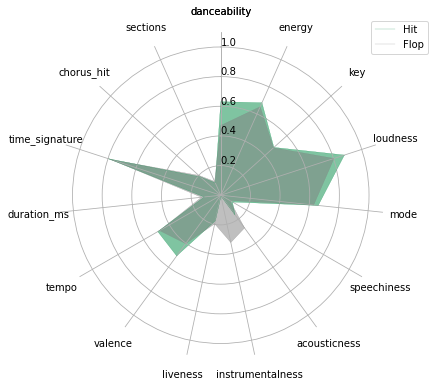

In [65]:
# between two groups
lbl = list(mean_st0['index'].values)
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(mean_st0))
plt.figure(figsize=(6,6))
ax = plt.subplot(polar=True)

#graph title
display(HTML(f'''<h3 style="text-align:center"> Figure 1:
                Hit vs Flop Averages
                </h3>'''))

#overall
ax.plot(label_loc, mean_st1[0], '#008B45', label='Hit', linewidth=0.2)
ax.fill(label_loc, mean_st1[0], '#008B45', alpha=.5)
ax.plot(label_loc, mean_st0[0], 'gray', label='Flop', linewidth=0.2)
ax.fill(label_loc, mean_st0[0], 'gray', alpha=.5)

ax.set_theta_offset(pi/2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
lines, labels = plt.thetagrids(np.degrees(label_loc),
                               labels=lbl)
plt.tick_params(axis='both', which='major', pad=10)
plt.legend(bbox_to_anchor=(1.15, 1.05), loc='upper right')
plt.ylim((0,1.1))
plt.box(on=None)

Looking at group averages (Figure 1), hit songs appear distinct from flops as they have higher valence, danceability and loudness. Hit songs also have lower instrumentalness and acousticness compared to flops.

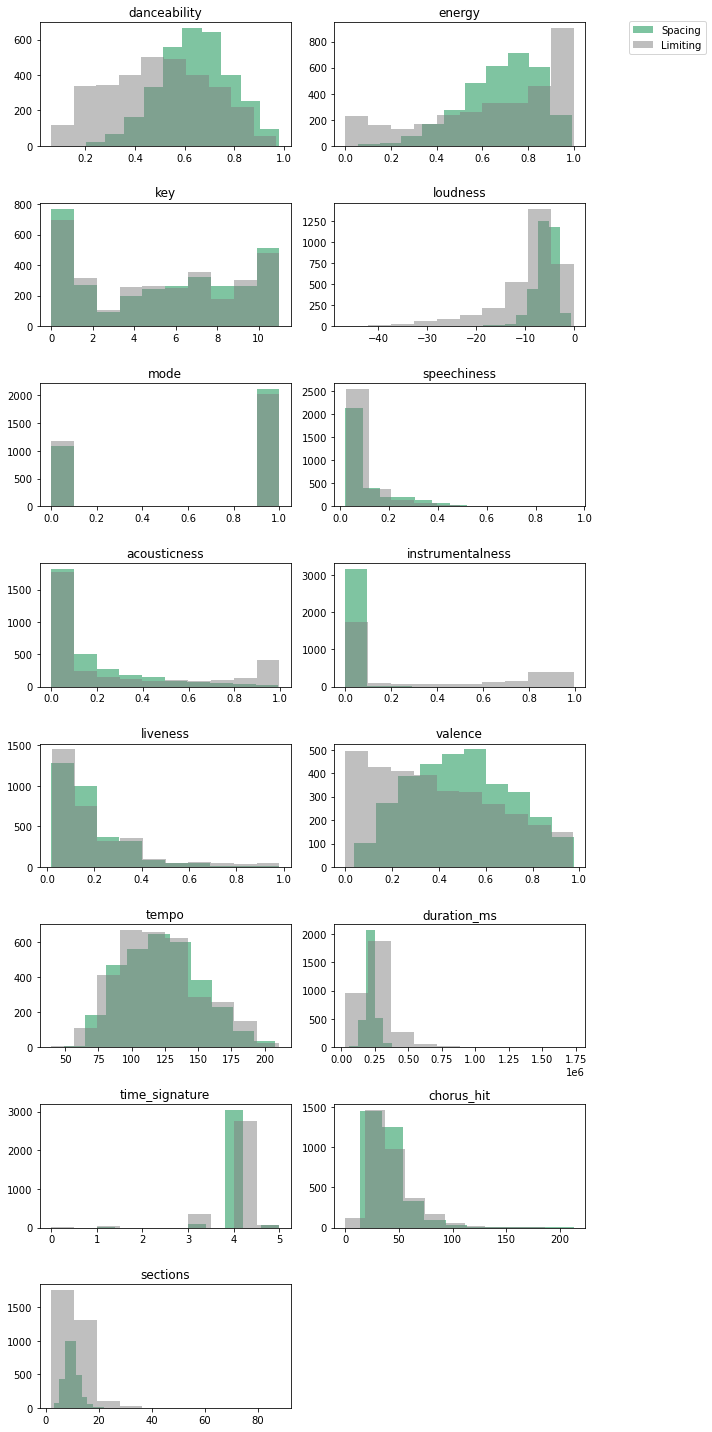

In [20]:
#graph title
display(HTML(f'''<h3 style="text-align:center"> Figure 2:
                Hit vs Flop Distribution
                </h3>'''))

# kde between 2 groups
plt.rcParams["figure.figsize"] = (10, 20)
test = df.iloc[:,3:]
for i,k in enumerate(radar.columns[:-1]):
    legend = True if i==1 else False
    ax = plt.subplot(8,2,i+1)
    ax = plt.hist(radar[radar.target == 1][k], alpha=0.5, color='#008B45')
    ax = plt.hist(radar[radar.target == 0][k], alpha=0.5, color='gray')
    if legend==True:
        plt.legend(bbox_to_anchor=(1.5, 1.05), labels=['Spacing','Limiting','Met'])
    plt.title(k)
    plt.tight_layout()

Figure 2 shows the distribution of each song feature for the hit and flop groups. Most distributions appear skewed with the exception of danceability and tempo. The flop group also appears to have more extreme values which will be explored further in the next charts.

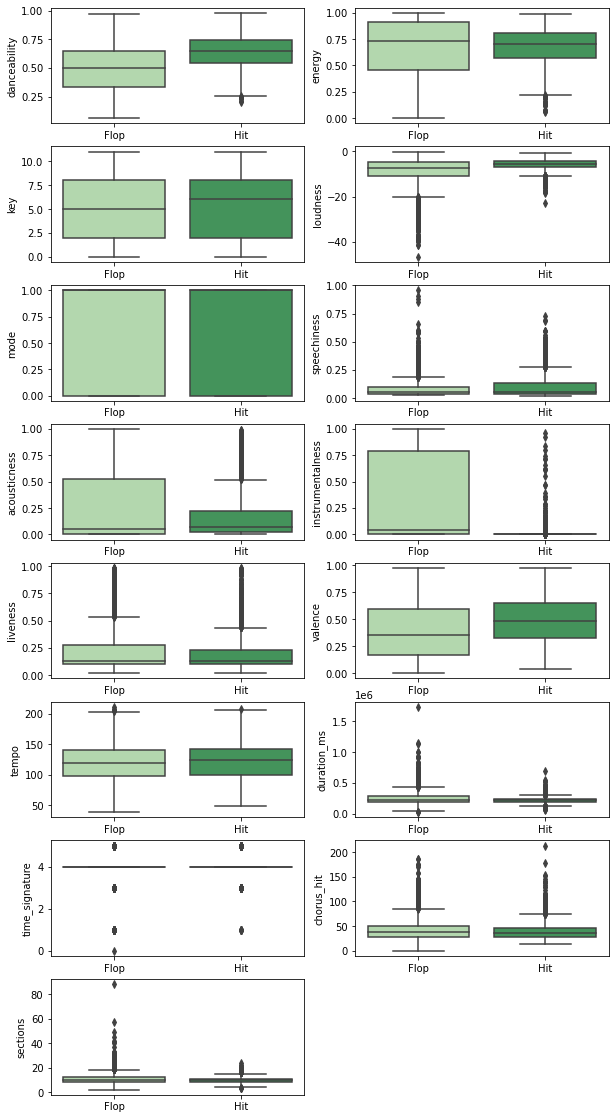

In [27]:
#graph title
display(HTML(f'''<h3 style="text-align:center"> Figure 3:
                Hit vs Flop Distribution
                </h3>'''))
plt.rcParams["figure.figsize"] = (10, 20)
for i,k in enumerate(test.columns[:-1]):
    ax = plt.subplot(8,2,i+1)
    sns.boxplot(data=test,
                x='target',
                y=k,
                ax=ax, palette='Greens')
    ax.set_xlabel(None)
    ax.set_xticklabels(['Flop','Hit'])
plt.show()

As we have seen in the distribution plots, significant outliers (Figure 3) appear for many of the features including loudness, speechiness, liveness, duration, time signature, sections, and chorus hit. Meanwhile, only the hit group has outliers for acousticness and instrumentalness.

## IV. Results and Discussion

<p style="text-align:justify">In this section, we will conduct statistical tests on the audio features as well as test the validity of these features for use in a L1-regularized logistic regression. </p>

### A. Tests for normality

<p style="text-align:justify">Test of normality is an important step for deciding the statistical procedure needed to compare groups. It will become the basis of decision whether to use a parametric test for normally distributed feature or a non-parametric test otherwise. The two most popular statistical tests of normality are <i>Shapiro Wilk</i> and <i>Kolmogorov-Smirnov </i>.</p>

<ul>
    <li><i>Shapiro Wilk</i> - based on the correlation between the sample percentile and normal percentile</li>
    <li><i>Kolmogorov-Smirnov</i> - based on the correlation between the sample cumulative distribution function and some theoretical cumulative distribution function<sup>11</sup></li>
</ul>

<p style="text-align:justify">For some literatures, it is always best to try <i>Shapiro Wilk</i> as it has more power than that of <i>Kolmogorov-Smirnov</i>. However, when the sample size is greater than 50, it is also good to check on the <i>Kolmogorov-Smirnov</i><sup>12</sup>. One problem for both is that they are prone to commit Type II error for very large sample sizes<sup>13</sup>. In this study, we explored using both of these statistical tests and verified the results by using q-q plots.</p>

<p style="text-align:justify">Formally, we represent these hypotheses as: </p>
<center><b><i>H<sub>0</sub></i></b> : data is normally distributed</center>
<center><b><i>H<sub>1</sub></i></b> : data is not normal distributed</center>

In [29]:
def normality(df, alpha=0.05):
    out = pd.DataFrame()
    
    for col in df.columns[:-1]:
        for i in range(2):
            # categorical/ordinal variables
            if col in ['key', 'mode', 'time_signature']:
                continue
            
            stat_sh, pvalue_sh = shapiro(df.loc[df.target==i, col].to_numpy())
            stat_ks, pvalue_ks = kstest(df.loc[df.target==i, col].to_numpy(),
                                       'norm')
            
            if pvalue_sh < alpha:
                decision_sh = "Reject H0"
            else:
                decision_sh = "Do Not Reject H0"
            
            if pvalue_ks < alpha:
                decision_ks = "Reject H0"
            else:
                decision_ks = "Do Not Reject H0"
            
            columns = pd.MultiIndex.from_product([['Shapiro Wilk', 
                                                   'Kolmogorov-Smirnov'], 
                                                  ['statistics', 'p-value', 
                                                   'alpha', 'decision']])
            
            data = np.array([round(stat_sh, 3), 
                             '{:.2e}'.format(float(pvalue_sh)), 
                             alpha, decision_sh,
                             round(stat_ks, 3), 
                             '{:.2e}'.format(float(pvalue_ks)), 
                             alpha, decision_ks])[None, :]
            
            
            index = pd.MultiIndex.from_product([[col], [i]],
                                   names=['feature', 'target'])
            
            temp = pd.DataFrame(data=data, columns=columns, index=index)

            out = pd.concat([out, temp], axis=0)
    
    return out

display(HTML(f'''<h3 style="text-align:left"> Table 4:
                Tests for Normality
                </h3>'''))
display(normality(df.loc[:, 'danceability':]))

Shapiro Wilk                             \
                          statistics   p-value alpha   decision   
feature          target                                           
danceability     0             0.983  4.51e-19  0.05  Reject H0   
                 1             0.996  1.53e-07  0.05  Reject H0   
energy           0             0.897  5.64e-42  0.05  Reject H0   
                 1              0.97  1.67e-25  0.05  Reject H0   
loudness         0             0.807  0.00e+00  0.05  Reject H0   
                 1             0.926  4.72e-37  0.05  Reject H0   
speechiness      0             0.657  0.00e+00  0.05  Reject H0   
                 1             0.736  0.00e+00  0.05  Reject H0   
acousticness     0             0.738  0.00e+00  0.05  Reject H0   
                 1             0.756  0.00e+00  0.05  Reject H0   
instrumentalness 0              0.74  0.00e+00  0.05  Reject H0   
                 1             0.095  0.00e+00  0.05  Reject H0   
liveness         0             0.734  0.00e+00  0.05  Reject H0   
                 1             0.766  0.00e+00  0.05  Reject H0   
valence          0             0.946  1.25e-32  0.05  Reject H0   
                 1             0.984  1.60e-18  0.05  Reject H0   
tempo            0             0.982  1.24e-19  0.05  Reject H0   
                 1             0.984  8.17e-19  0.05  Reject H0   
duration_ms      0             0.831  0.00e+00  0.05  Reject H0   
                 1             0.918  1.26e-38  0.05  Reject H0   
chorus_hit       0             0.858  0.00e+00  0.05  Reject H0   
                 1             0.844  0.00e+00  0.05  Reject H0   
sections         0             0.815  0.00e+00  0.05  Reject H0   
                 1             0.968  3.05e-26  0.05  Reject H0   

                        Kolmogorov-Smirnov                             
                                statistics   p-value alpha   decision  
feature          target                                                
danceability     0                   0.531  0.00e+00  0.05  Reject H0  
                 1                   0.613  0.00e+00  0.05  Reject H0  
energy           0                     0.5  0.00e+00  0.05  Reject H0  
                 1                     0.6  0.00e+00  0.05  Reject H0  
loudness         0                    0.97  0.00e+00  0.05  Reject H0  
                 1                   0.976  0.00e+00  0.05  Reject H0  
speechiness      0                   0.509  0.00e+00  0.05  Reject H0  
                 1                   0.509  0.00e+00  0.05  Reject H0  
acousticness     0                     0.5  0.00e+00  0.05  Reject H0  
                 1                     0.5  0.00e+00  0.05  Reject H0  
instrumentalness 0                     0.5  0.00e+00  0.05  Reject H0  
                 1                     0.5  0.00e+00  0.05  Reject H0  
liveness         0                    0.51  0.00e+00  0.05  Reject H0  
                 1                   0.508  0.00e+00  0.05  Reject H0  
valence          0                   0.509  0.00e+00  0.05  Reject H0  
                 1                   0.522  0.00e+00  0.05  Reject H0  
tempo            0                     1.0  0.00e+00  0.05  Reject H0  
                 1                     1.0  0.00e+00  0.05  Reject H0  
duration_ms      0                     1.0  0.00e+00  0.05  Reject H0  
                 1                     1.0  0.00e+00  0.05  Reject H0  
chorus_hit       0                   0.998  0.00e+00  0.05  Reject H0  
                 1                     1.0  0.00e+00  0.05  Reject H0  
sections         0                   0.996  0.00e+00  0.05  Reject H0  
                 1                   0.999  0.00e+00  0.05  Reject H0

<p style="text-align:justify">The results for both <i>Shapiro Wilk</i> and <i>Kolmogorov-Smirnov</i> (Table 4) with 95% confidence interval show that all of our continuous features do not follow a normal distribution. Visually, we can check the q-q plots to assess if our statistical tests are just being sensitive. q-q plot is a visual representation that lets us know the if the data follows a certain distribution by means of quantiles<sup>14</sup>.</p>

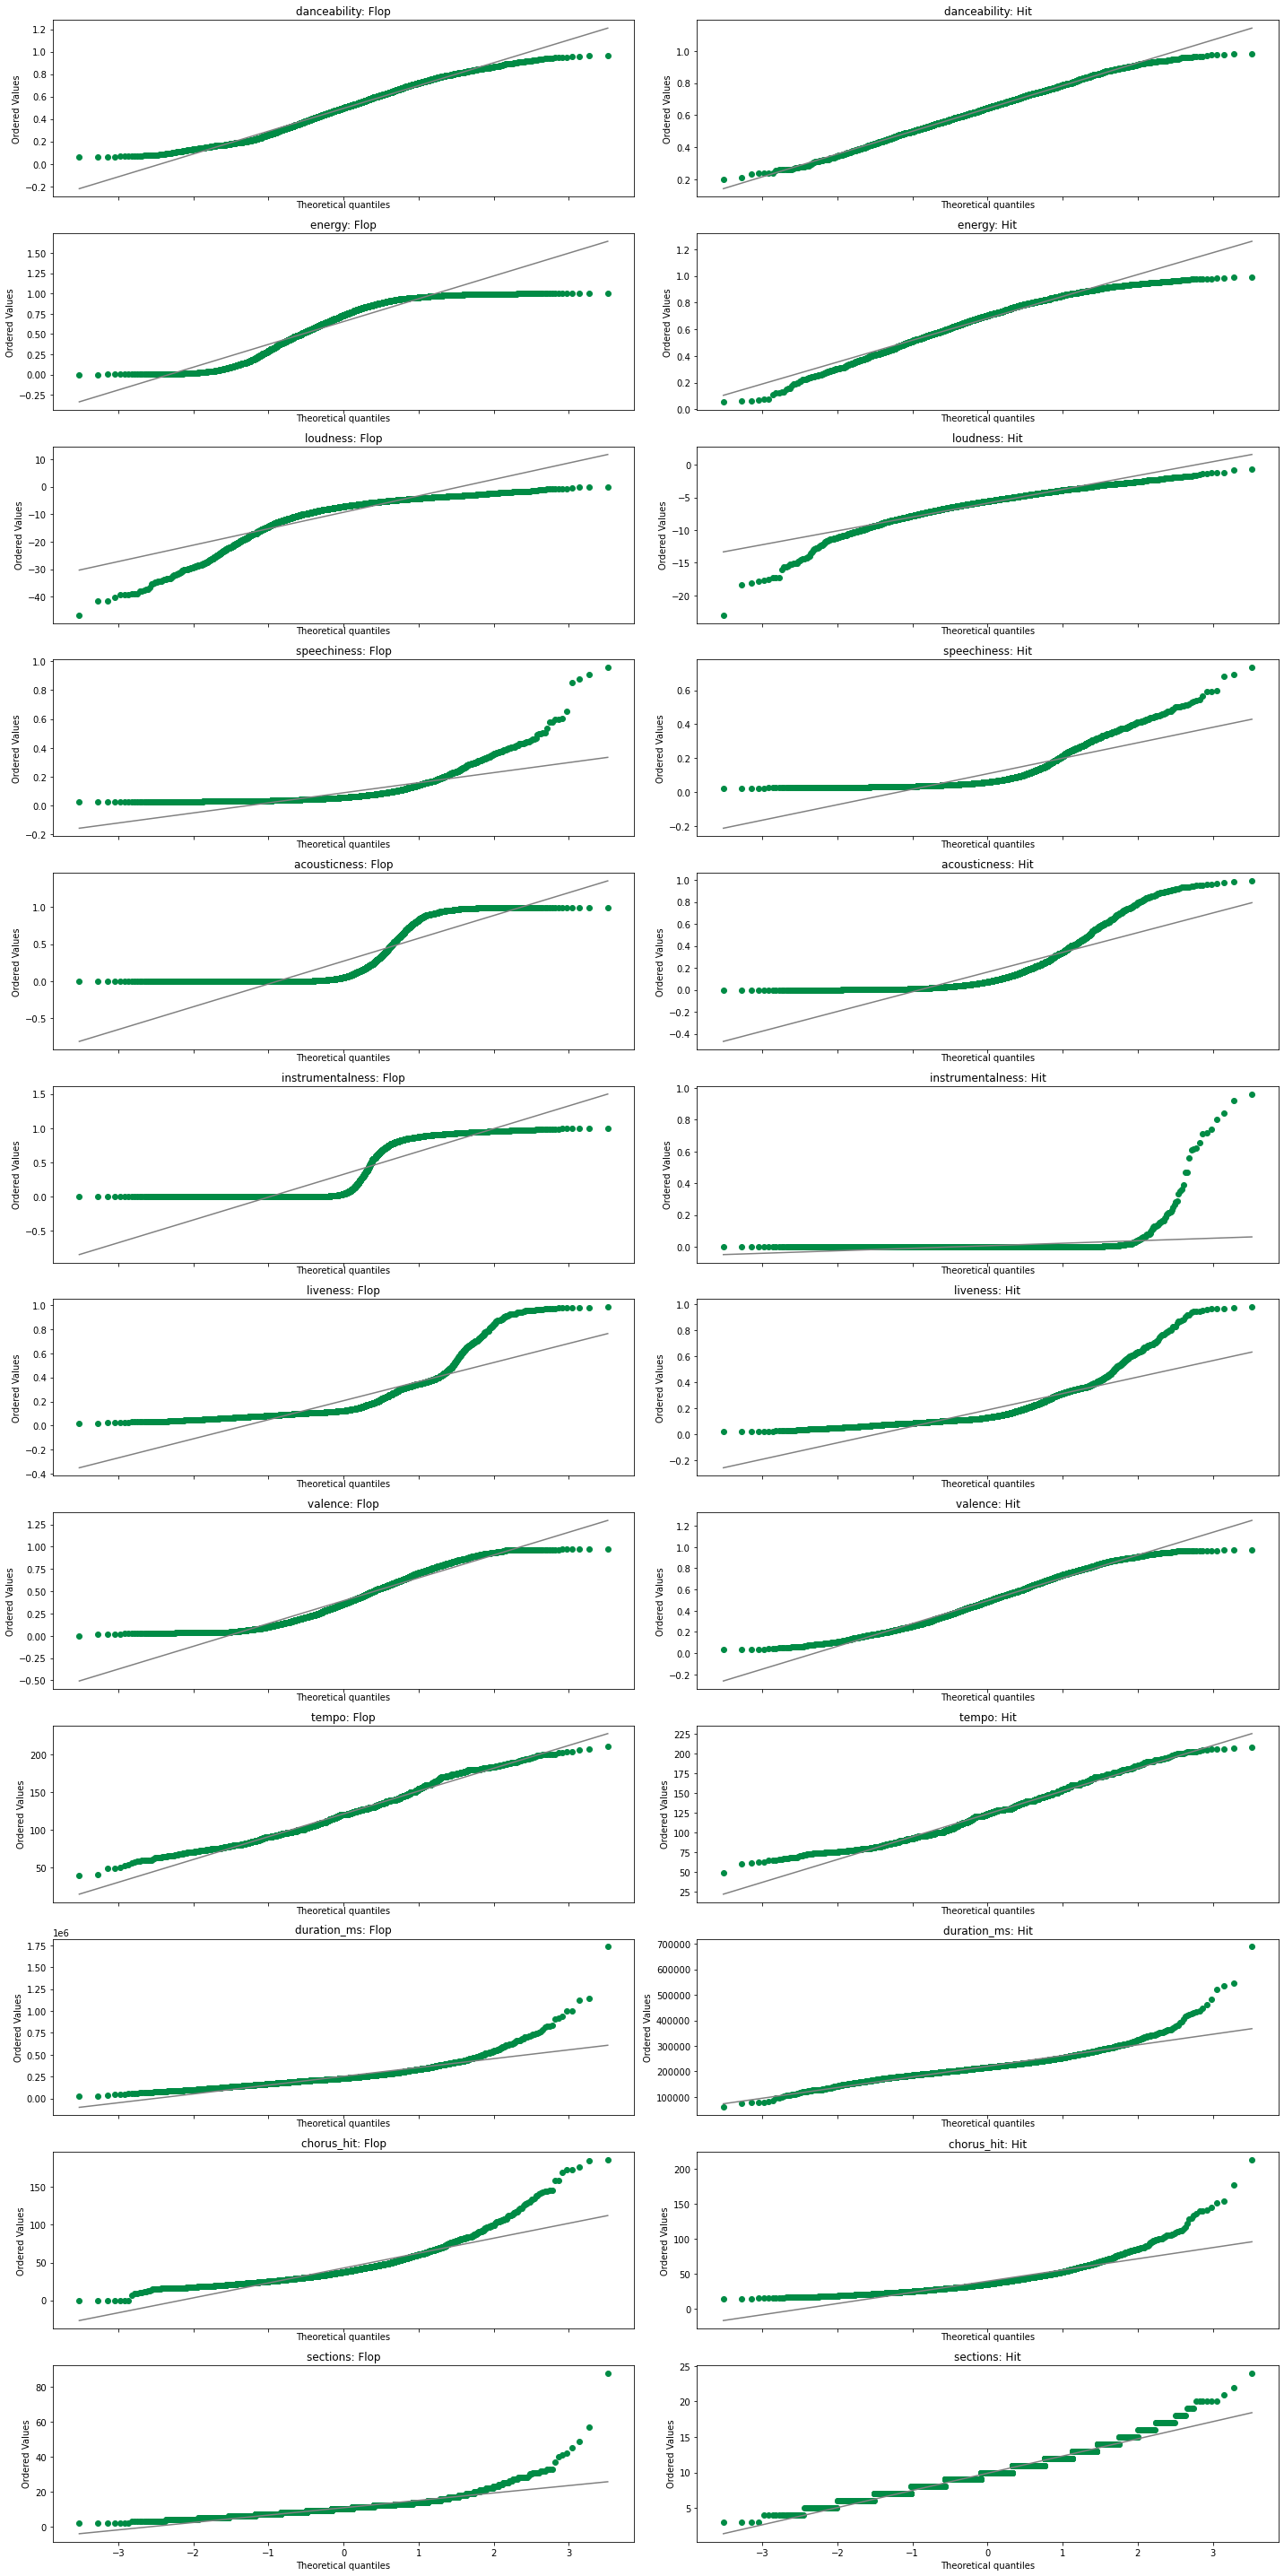

In [37]:
def plot_qq(df):
    fig, axes = plt.subplots(len(df.columns) -4, 2,
                             figsize=(20, 40), sharex=True)
    axes = axes.flatten()
    
    cnt = 0
    for col in df.columns[:-1]:
        # categorical/ordinal variables
        if col in ['key', 'mode', 'time_signature']:
                continue
        
        for i in range(2):
            label = ['Flop','Hit']
            ax = axes[cnt]
            test_df = df.loc[df.target==i, col].to_numpy()
            probplot(test_df, dist = "norm", plot = ax)
            ax.get_children()[0].set_color('#008B45')
            ax.get_children()[1].set_color('gray')
            ax.set_title(f'{col}: {label[i]}')
            cnt += 1
    plt.tight_layout()
    return ax

display(HTML(f'''<h3 style="text-align:center"> Figure 4:
                Q-Q plots
                </h3>'''))
plot_qq(df.loc[:, 'danceability':]);

<p style="text-align:justify">We could say that our data follows a normal distribution if the sample quantiles (scatter) are fitted in the normal quantiles (line). Looking at Figure 4, we can see that all of our features separate at the tail end. Danceability and tempo seem to be closest to having normal distribution but showed some level of thinness of tails<sup>15</sup>. With this information, we could say that our statistical tests are indeed correct that none our continuous features follow a normal distribution. Therfore, a <b>non-parametric</b> test is needed to compare the two groups.</p>

### B. Mann-Whitney U Test

<p style="text-align:justify">In this study, we used Mann-Whitney U test to compare two sample means. It is a non-parametric test which means it does not assume any assumption with regards to distribution. However, the test does require some assumptions to be made.</p>

<b>Assumptions of Mann Whitney U<sup>16</sup>:</b>
<ol>
    <li>dependent variables should be measured at the ordinal or continuous level</li>
    <li>independent variables should consist of two categorical, independent groups.</li>
    <li>independence of observations</li>
    <li>not normally distributed</li>
 </ol>
 
<p style="text-align:justify">All of these assumptions are met with our data: our dependent variables are all ordinal or continuous (danceability, tempo, etc); our independent variable consists of a categorical group (hit or not hit); each observation is an individual song thus independent of others; and finally, our data is not normally distributed hence our use of non-parametric test.</p>
 
 <p style="text-align:justify">Formally, we represent these hypotheses as: </p>
<center><b><i>H<sub>0</sub></i></b> : the distributions of "hit" and "flop" are equal</center>
<center><b><i>H<sub>1</sub></i></b> : the distributions of "hit" and "flop" are not equal</center>

In [39]:
def mean_test(df, alpha=0.05):
    out = pd.DataFrame()
    
    for col in df.columns[:-1]:
        negative_class = df.loc[df.target==0, col].to_numpy()
        positive_class = df.loc[df.target==1, col].to_numpy()
        
        stat, pvalue = mannwhitneyu(negative_class, 
                                    positive_class, 
                                    alternative='two-sided')
        if pvalue < alpha:
            decision = "Reject H0"
        else:
            decision = "Do Not Reject H0"
        temp = pd.DataFrame({'column' : col,
                             'statistics': stat,
                             'p-value' : pvalue,
                             'alpha' : alpha, 
                             'decision': decision}, index=[0])

        out = pd.concat([out, temp], axis=0)
    
    return out.reset_index(drop=True)


display(HTML(f'''<h3 style="text-align:left"> Table 5:
                Mann-Whitney U Test Results
                </h3>'''))
display(mean_test(df.loc[:, 'danceability':]))

,column,statistics,p-value,alpha,decision
0,danceability,2964852.5,1.461886e-186,0.05,Reject H0
1,energy,5406589.0,8.750881e-05,0.05,Reject H0
2,key,5083369.0,6.494958e-01,0.05,Do Not Reject H0
3,loudness,3464168.5,7.447737e-111,0.05,Reject H0
4,mode,4960049.5,1.043594e-02,0.05,Reject H0
5,speechiness,4888182.0,1.969516e-03,0.05,Reject H0
6,acousticness,4789477.5,9.382119e-06,0.05,Reject H0
7,instrumentalness,8641926.5,0.000000e+00,0.05,Reject H0
8,liveness,5188598.5,3.310854e-01,0.05,Do Not Reject H0
9,valence,3851646.0,9.443943e-66,0.05,Reject H0


<p style="text-align:justify">From the results of our Mann-Whitney U Test (Table 5), with 95% confidence level, we can infer the following insights:</p>
<ul>
    <li>key and liveness have equal distributions</li>
</ul>


### C. Multicollinearity
Multicollinearity between variables can cause logistic regression to have unstable estimates and inaccurate variances thus, we would like this to be as low as possible.

##### Correlation heatmap

A quick look at the correlation heatmap (Figure 5) reveals some highly-correlated variables. For instance, duration_ms and sections show a strong positive correlation coefficient of 0.81. On the other hand, significant negative correlation can be seen between energy and acousticness and also between loudness and acousticness. These strong correlations suggest that a deeper multicollinearity assessment should be performed on the data to make it suitable for logistic regression modeling.

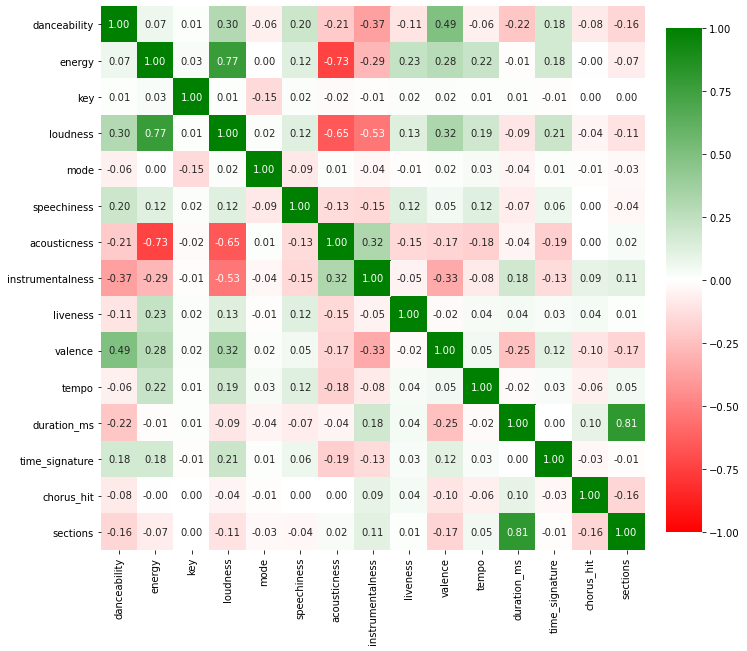

In [14]:
#correlation plot
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','green']
)

X_mc = df.loc[:, 'danceability': 'sections']
corr = X_mc.corr()
fig, ax = plt.subplots(1, 1, figsize=(10,10))
cbar_ax = fig.add_axes([.92, .15, .05, .7])
display(HTML(f'''<h3 style="text-align:center">Figure 5. Correlation plots
                    between variables</h3>'''))
sns.heatmap(corr, ax=ax,
            vmin=-1, vmax=1, center=0,
           cmap=cmap, square=True, annot=True, fmt=".2f",#linewidths=.5,
           # xticklabels=cols,
            cbar_ax=cbar_ax,
            cbar_kws={"orientation": "vertical"});

##### Variance Inflation Factor

For testing multicollinearity, we will be using Variance Inflation Factor (VIF) which measures the amount of multicollinearity in a set of multiple regression variables. For this test, we will adopt a VIF threshold of < 10 in accordance with generally accepted heuristics.<sup>17</sup>

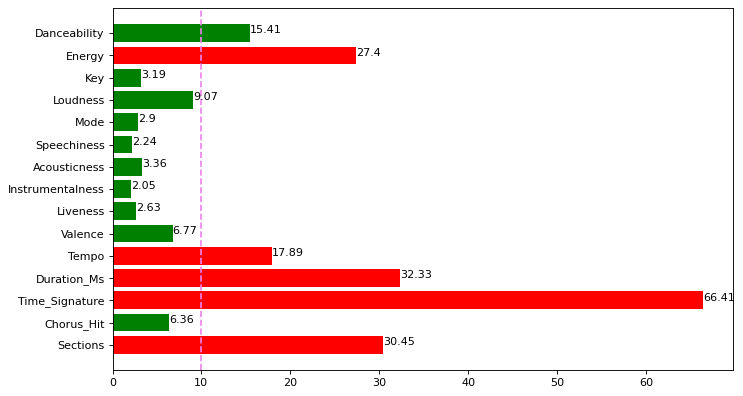

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_mc.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_mc.values, i)
                   for i in range(len(X_mc.columns))]

# Plotting VIF
display(HTML(f'''<h3 style="text-align:center">Figure 6. VIF Chart prior feature removal</h3>'''))
plt.figure(figsize=(10, 6), dpi=80)
plt.barh(vif_data.feature[::-1].str.title(), vif_data.VIF[::-1],
         color=['green', 'red', 'green', 'green', 'green', 'green', 'green',
                'green', 'green', 'green', 'red', 'red', 'red', 'green',
                'red'][::-1])
plt.axvline(x=10, color='violet', linestyle='--')
for index, value in enumerate(vif_data.VIF[::-1]):
    plt.text(value, index, str(round(value, 2)))
plt.show()

Looking at Figure 6, features showing high multicollinearity include most time-related features like `tempo`, `duration_ms`, `time_signature`, and `sections`. Hence, these features will be discarded to minimize multicollinearity for our data.

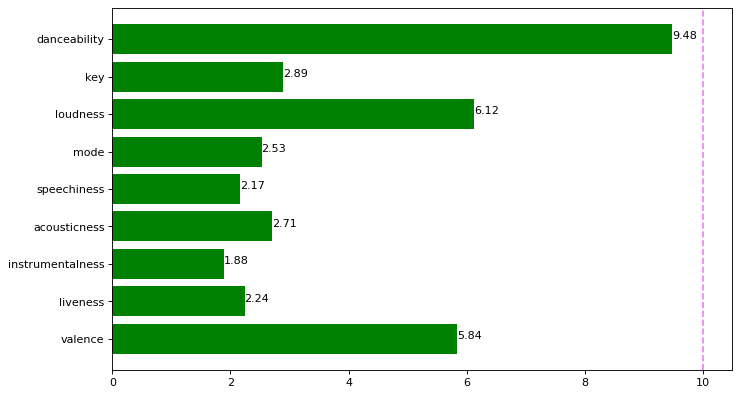

In [16]:
X_mc = df.loc[:, ['danceability', 'key', 'loudness', 'mode',
                  'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_mc.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_mc.values, i)
                   for i in range(len(X_mc.columns))]


# Plotting VIF
display(HTML(f'''<h3 style="text-align:center">Figure 7. VIF Chart after feature removal</h3>'''))
plt.figure(figsize=(10, 6), dpi=80)
plt.barh(vif_data.feature[::-1], vif_data.VIF[::-1], color='green')
plt.axvline(x=10, color='violet', linestyle='--')
for index, value in enumerate(vif_data.VIF[::-1]):
    plt.text(value, index, str(round(value, 2)))
plt.show()

Removal of the identified highly multicollinear features enabled the minimization of all VIF scores to under 10, with danceability having the highest at 9.48 (Figure 7). Therefore, retention only of these remaining features would enable the data to meet the non-multicollinearity criteria of logistic regression.

### D. Test of Linearity with  Log-odds

Although logistic regression does not necessitate that continuous predictor variables be linearly related to the target variable, it does require these predictor variables to be linearly related to the log odds of the target variable. Hence, we perform a test of linearity with log-odds on the remaining continuous predictor variables after having conducted the preceding statistical tests. We do this by using the Seaborn statistical plotting library.$^{18}$

In [3]:
df_bt=df[['danceability', 'key', 'loudness', 'mode', 'speechiness', 
          'acousticness', 'instrumentalness', 'liveness', 'valence', 
          'target']]

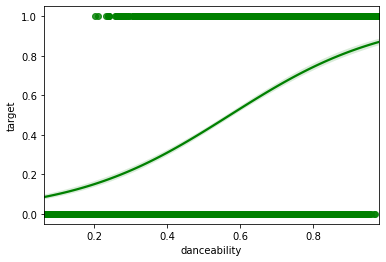

In [4]:
test_dance = sns.regplot(x='danceability', y='target', data=df_bt, logistic=True, color='green')
display(HTML(f'''<h3 style="text-align:left">Table 8. Danceability Log Odds Linear Plot</h3>'''))
test_dance.figure.savefig("danceability log lin.png")

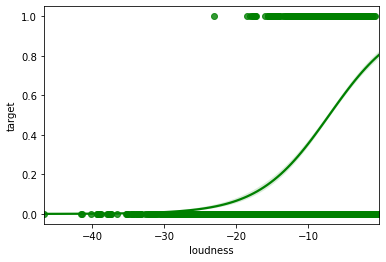

In [5]:
test_loudness = sns.regplot(x='loudness', y='target', data=df_bt, logistic=True, color='green')
display(HTML(f'''<h3 style="text-align:left">Table 9. Loudness Log Odds Linear Plot</h3>'''))
test_loudness.figure.savefig("loudness log lin.png")

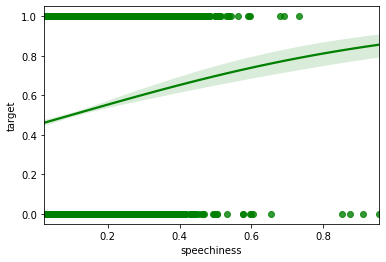

In [6]:
test_speechiness = sns.regplot(x='speechiness', y='target', data=df_bt, logistic=True, color='green')
display(HTML(f'''<h3 style="text-align:left">Table 10. Speechiness Log Odds Linear Plot</h3>'''))
test_speechiness.figure.savefig("speechiness log lin.png")

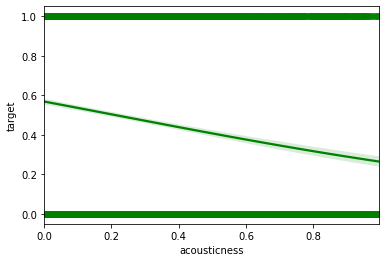

In [7]:
test_acousticness = sns.regplot(x='acousticness', y='target', data=df_bt, logistic=True, color='green')
display(HTML(f'''<h3 style="text-align:left">Table 11. Acousticness Log Odds Linear Plot</h3>'''))
test_acousticness.figure.savefig("acousticness log lin.png")

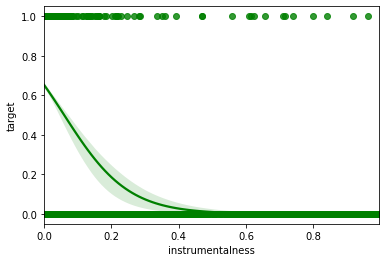

In [8]:
test_instrumentalness = sns.regplot(x='instrumentalness', y='target', data=df_bt, logistic=True, color='green')
display(HTML(f'''<h3 style="text-align:left">Table 12. Instrumentalness Log Odds Linear Plot</h3>'''))
test_instrumentalness.figure.savefig("instrumentalness log lin.png")

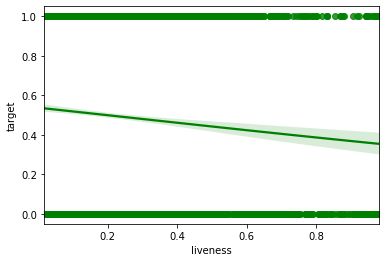

In [9]:
test_liveness = sns.regplot(x='liveness', y='target', data=df_bt, logistic=True, color='green')
display(HTML(f'''<h3 style="text-align:left">Table 13. Liveness Log Odds Linear Plot</h3>'''))
test_liveness.figure.savefig("liveness log lin.png")

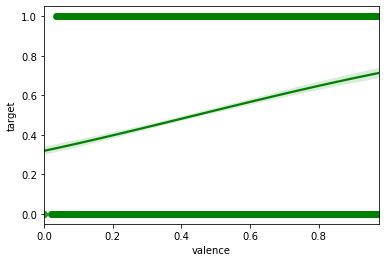

In [10]:
test_valence = sns.regplot(x='valence', y='target', data=df_bt, logistic=True, color='green')
display(HTML(f'''<h3 style="text-align:left">Table 14. Valence Log Odds Linear Plot</h3>'''))
test_valence.figure.savefig("valence log lin.png")

To satisfy the assumption that the continuous predictor variables are linearly related to the log odds, the plots should show an S-shaped or reverse S-shaped curve - flat top and bottom with an increase/decrease in the middle. All the plots above satisfy this requirement. We can therefore say that all the remaining features fulfill the requirements for linearity with log odds.

### E. Logistic Regression

Logistic regression is a commonly-used classification algorithm when the target variable is binary (i.e. either 0 or 1). From the results of the multicollinearity tests, we have selected the following feature variables to use for our classification:

- danceability
- key
- loudness
- mode
- speechiness
- acousticness
- instrumentalness
- liveness
- valence

Upon checking these features differ in units and magnitude (Table 6), so we transform the data using the StandardScaler to improve the model's accuracy and interpretability.

In [13]:
mm = pd.DataFrame(index=X_mc.columns, columns=['min', 'max'])
for i in X_mc.columns:
    mm.loc[i, 'min'] = min(X_mc[i])
    mm.loc[i, 'max'] = max(X_mc[i])
display(HTML(f'''<h3 style="text-align:left">Table 6. Minimum and Maximum of Predictors</h3>'''))
mm

,min,max
danceability,0.0622,0.981
key,0,11
loudness,-46.655,-0.149
mode,0,1
speechiness,0.0225,0.956
acousticness,0.0,0.996
instrumentalness,0.0,0.995
liveness,0.0167,0.982
valence,0.0,0.976


In [48]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler().fit(X_mc)
X_log = Scaler.transform(X_mc)

We applied Grid Search on Logistic Regression to find the best possible C parameter using Repeated Stratified KFold on 10 splits and 10 repeats. We chose to implement Logistic Regression with L1-regularization since this method leads to feature selection. Results of Grid Search over parameters

<code>C = [1e-5, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10_000, 100_000]</code>

are given below:

In [49]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

y = df['target']

C_range = [1e-5, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10_000, 100_000]

rskf = RepeatedStratifiedKFold(n_splits=10,
                               n_repeats=10)
estimator = LogisticRegression(penalty='l1', solver='liblinear')
param_grid = {'C': C_range}
gs_lr = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=rskf)
gs_lr.fit(X_log, y);

In [20]:
results_df = pd.DataFrame(gs_lr.cv_results_)
display(HTML(f'''<h3 style="text-align:left">Table 7. Results of Grid Search CV</h3>'''))
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split93_test_score,split94_test_score,split95_test_score,split96_test_score,split97_test_score,split98_test_score,split99_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004630,0.000763,0.000497,0.000099,0.00001,{'C': 1e-05},0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.499218,0.500782,0.500000,0.000350,10
1,0.005503,0.000584,0.000500,0.000081,0.001,{'C': 0.001},0.723437,0.685937,0.701562,0.712500,...,0.718750,0.704688,0.695312,0.698438,0.723437,0.716745,0.708920,0.710847,0.011409,9
2,0.007702,0.000954,0.000462,0.000079,0.01,{'C': 0.01},0.781250,0.748437,0.750000,0.778125,...,0.776563,0.757812,0.765625,0.764062,0.771875,0.762128,0.755869,0.764911,0.012429,8
3,0.016122,0.001498,0.000504,0.000086,0.1,{'C': 0.1},0.796875,0.759375,0.762500,0.796875,...,0.779687,0.775000,0.771875,0.781250,0.793750,0.766823,0.760563,0.774492,0.014439,7
4,0.020239,0.002483,0.000489,0.000075,1,{'C': 1},0.793750,0.757812,0.764062,0.803125,...,0.779687,0.775000,0.773438,0.784375,0.798438,0.763693,0.762128,0.776258,0.014293,4
5,0.021582,0.002357,0.000524,0.000087,10,{'C': 10},0.793750,0.757812,0.762500,0.803125,...,0.778125,0.775000,0.773438,0.784375,0.798438,0.765258,0.762128,0.776196,0.014218,6
6,0.022239,0.002180,0.000528,0.000081,100,{'C': 100},0.793750,0.757812,0.762500,0.803125,...,0.778125,0.776563,0.775000,0.784375,0.798438,0.765258,0.762128,0.776258,0.014223,3
7,0.022139,0.002253,0.000525,0.000073,1000,{'C': 1000},0.793750,0.757812,0.762500,0.803125,...,0.779687,0.776563,0.775000,0.784375,0.798438,0.765258,0.762128,0.776274,0.014244,1
8,0.021485,0.002459,0.000502,0.000082,10000,{'C': 10000},0.793750,0.757812,0.762500,0.803125,...,0.779687,0.776563,0.775000,0.784375,0.798438,0.765258,0.762128,0.776258,0.014239,2
9,0.022095,0.002540,0.000517,0.000084,100000,{'C': 100000},0.793750,0.757812,0.762500,0.803125,...,0.778125,0.776563,0.775000,0.784375,0.798438,0.765258,0.762128,0.776242,0.014243,5


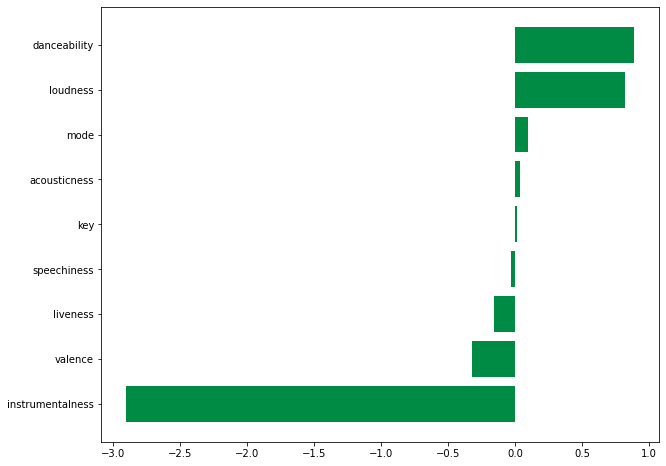

In [52]:
best_log = LogisticRegression(C=1_000, penalty='l1', solver='liblinear')
best_log.fit(X_log,y)
coefs_count = len(X_mc.columns)

display(HTML(f'''<h3 style="text-align:center">Figure 15. Average Coefficients</h3>'''))

fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.barh(np.arange(coefs_count), sorted(best_log.coef_[0]), color='#008B45')
ax.set_yticks(np.arange(coefs_count))
ax.set_yticklabels(X_mc.columns[np.argsort(best_log.coef_[0])])
plt.show()

In [59]:
X_stats = sm.add_constant(X_log)
display(HTML(f'''<h3 style="text-align:left">Table 8. Results of Logistic Regression</h3>'''))
# Use statsmodels to fit logit
logit = sm.Logit(y, X_stats).fit_regularized(method='l1', alpha=1/1_000)

# Print summary and marginal effects

print(logit.summary())
print(logit.get_margeff().summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4666756210151764
            Iterations: 40
            Function evaluations: 40
            Gradient evaluations: 40
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 6398
Model:                          Logit   Df Residuals:                     6388
Method:                           MLE   Df Model:                            9
Date:                Wed, 15 Sep 2021   Pseudo R-squ.:                  0.3267
Time:                        12:57:13   Log-Likelihood:                -2985.8
converged:                       True   LL-Null:                       -4434.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


In [56]:
from sklearn.metrics import accuracy_score
pred = logit.predict()
#accuracy_score(np.where(pred >= 0.5, 1, 0), y)

In [60]:
from sklearn.metrics import classification_report
display(HTML(f'''<h3 style="text-align:left">Table 9. Classification Report</h3>'''))
print(classification_report(y,np.where(pred >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.87      0.66      0.75      3199
           1       0.72      0.90      0.80      3199

    accuracy                           0.78      6398
   macro avg       0.79      0.78      0.77      6398
weighted avg       0.79      0.78      0.77      6398



The classification report for the resulting logistic regression model given by Table 9 has an overall accuracy of 78 percent. If we take hit songs as the relevant case for the dataset, the precision implies that the model can accurately identify hit songs by 72 percent. While recall of 0.90 suggests that the model can find 90 percent of hit songs in the data.

<p style="text-align:justify">From the results of the logistic regression, the features with the highest marginal effects (in absolute value) are <b><i>valence, danceability, and instrumentalness</i></b>.  This shows that valence and danceability provide the most positive impact in songs getting closer to a hit chart. Meanwhile, instrumentalness provides the most negative impact in songs, limiting the chances of landing on the hit charts.  Key, speechinees and acousticness were found to not significantly impact the likelihood of being a hit song. Though other features also have marginal effects, their magnitude is considerable lower than the top 3 so we can consider the impact of these features to be insubstantial.

Looking closer at the marginal effects, instrumentalness outweighs the combined impact of valence and danceability.  Therefore, for a song to reach the hit charts, the feature score of both valence and danceability should exceed the feature score of instrumentalness by at least twice to surpass the negative impact.

## V. Conclusion

<p style="text-align:justify">
Using the 2010-2019 Spotify Hits Predictor Dataset from Kaggle, we attempt to reveal the combination of audio features that determine hit songs from flops using a logistic regression.
<br><br>Looking into the general composition of audio features between hits and flops, we visually confirm differences in the means and distributions between the two groups. To test the statistical significance of these differences, we use Mann-Whitney U test for means since our features were found to be non-normally distributed.
<br><br>
After statistically confirming the differences between the means of the two groups, we then assessed the validity of the model and its potential predictors by testing for multicollinearity and linearity with log-odds. Energy and time-related variables were dropped to meet the assumptions of a logistic regression to allow for valid interpretations of the resulting summary statistics. After implementing a grid search over 10 trials and 10 splits, we then implemented an L1-regularized logistic regression using the C parameter with the highest test accuracy.
<br><br> The resulting model has an accuracy score of 78 percent. Summary statistics show that positive and danceable songs have higher chances of hitting the charts. Meanwhile, instrumentalness outweighs the combined impact of valence and danceability. So if the song is predicted to reach the hit charts, the feature score of both valence and danceability should exceed the feature score of instrumentalness by at least 2 times to surpass the negative impact. This suggests that a balance of certain features can contribute to a song's mass appeal and can land it at the top of the charts.
<br><br>This study can potentially help artists and music producers find commercial success by producing songs that fit the standard of those that land on the charts. Recording companies can also predict the potential success of songs they will be releasing based on the song's audio features.

</p>

## VI. Recommendations

<p style="text-align:justify">
In this report, we assumed that the mix of audio features plays the most important role in deciding whether a song will enter the weekly Billboard's Hot 100 list or not. However, it can be argued that in reality, song lyrics also have a significant impact on the commercial success of a song. Hence, for further studies on the topic, we recommend that datasets and analysis on song lyrics be included as well to provide a more solid conclusion. We also propose to extend the dataset to include songs from earlier decades and analyze the changes in the impact of different features over time. Moreover, the datasets of a more globalized version of the music industry standard be used in place of the Billboard chart. This will entail a more extensive study but in turn, will produce more generalized results.
Another recommendation for further studies is to look into local hit charts. This will allow for comparison among preferences locally and internationally. Furthermore, the study will also be made more relatable to the local audience.
</p>

## References

[1] Company, Houghton Mifflin Harcourt Publishing. "The American Heritage Dictionary entry: Music". ahdictionary.com. Retrieved 2021-01-20.

[2] Popular Music. (2015). Funk & Wagnalls New World Encyclopedia

[3] Reece, K. (2018). *Why Pop Music is Bad.* Medium. https://medium.com/@18kreece/why-pop-music-is-bad-67db0ae4cce2

[4] Python for Data Science. (n.d.). *Logistic Regression.* https://pythonfordatascienceorg.wordpress.com/logistic-regression-python/

[5] Chen, E. (2018). *Logistic Regression.* Blogspot. http://edchentech.blogspot.com/2018/06/logistic-regression.html?m=1

[6] Kaggle. Spotify Hits Predictor Dataset. https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset

[7] Spotify. Web API Reference. https://developer.spotify.com/documentation/web-api/reference/#object-audiofeaturesobject

[8] Billboard. (2012). *The Best of 2012: The Year In Music.* https://www.billboard.com/articles/news/1481472/the-best-of-2012-the-year-in-music

[9] Vanity Fair. (2019). *10 Songs That Explain the 2010s.* https://www.vanityfair.com/style/2019/12/songs-of-the-decade-2010s

[10] Wikipedia. Billboard Hot 100. https://en.wikipedia.org/wiki/Billboard_Hot_100

[11] Mishra, S. (2020) *Methods for Normality Test with Application in Python.* Towards Data Science. https://towardsdatascience.com/methods-for-normality-test-with-application-in-python-bb91b49ed0f5

[12] Mishra, P. et al. (2019). *Descriptive Statistics and Normality Tests for Statistical Data.* National Center for Biotechnology Information. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/

[13] Tsagris, M. & Pandis, N. (2021) *Normality test: Is it really necessary?* American Journal of Orthodontics and Dentofacial Orthopedics. https://www.ajodo.org/article/S0889-5406(21)00038-X/fulltext

[14] Lewinson, S. (2019) *Explaining probability plots.* Towards Data Science. https://towardsdatascience.com/explaining-probability-plots-9e5c5d304703

[15] Varshney, P. (2020) *Q-Q Plots Explained.* Towards Data Science. https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0

[16] Laerd Statistics. Mann-Whitney U Test using SPSS Statistics. https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php

[17] Choueiry, George (2020) *What is an Acceptable Value for VIF?* Quantifying Health. https://quantifyinghealth.com/vif-threshold/

[18] Python for Data Science. Logistic Regression. https://pythonfordatascienceorg.wordpress.com/logistic-regression-python/